# NO$_3$ Interannual variability analysis (MARBL-SPECTRA COREv2 forcing)

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Find the coordiantes to separate the Arctic Ocean, the way that we did for the 1v1 grid in SPECTRA

| Initials  | Name                       | Latitude          | Longitude             |
|-----------|----------------------------|-------------------|-----------------------|
| `ao`      | Central Arctic             | $90^oN$ to $80^oN$ |  All                 |
| `cs`      | Chukchi Sea                | $80^oN$ to $60^oN$ |$-180^o$ to $-155^oW$ |
| `bs`      | Beaufort Sea               | $80^oN$ to $60^oN$ |$-155^oW$ to $-125^oW$|
| `ca`      | Canadian Archipelago       | $80^oN$ to $60^oN$ |$-125^oW$ to $-70^oW$ |
| `bb`      | Baffin Sea                 | $80^oN$ to $60^oN$ |$-70^oW$ to $-45^oW$  |                      
| `ess`     | Eastern Siberian Sea       | $80^oN$ to $60^oN$ |$145^oE$ to $180^o$   |                       
| `ls`      | Laptev Sea                 | $80^oN$ to $60^oN$ |$90^oE$ to $145^oE$   |                      
| `ks`      | Kara Sea                   | $80^oN$ to $60^oN$ |$53^oE$ to $90^oE$    |                      
| `bts`     | Barents Sea                | $80^oN$ to $60^oN$ |$20^oE$ to $53^oE$    |                      
| `ns`      | Nordic Sea                 | $80^oN$ to $60^oN$ |$-45^oW$ to $20^oE$   | 

In [5]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_NO3*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [6]:
temp_ds_inter = np.empty([63,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    temp_ds_inter[i,:,:,:] = ds.NO3[x[i]:x[i]+12,0,:,:]

In [7]:
temp_ao = np.nanmean(temp_ds_inter[:,:,170:180,:], axis=(2,3))
temp_cs = np.nanmean(temp_ds_inter[:,:,149:170,0:25], axis = (2,3))
temp_bs = np.nanmean(temp_ds_inter[:,:,149:170,25:55], axis = (2,3))
temp_ca = np.nanmean(temp_ds_inter[:,:,149:170,55:110], axis = (2,3))
temp_bb = np.nanmean(temp_ds_inter[:,:,149:170,110:135], axis = (2,3))
temp_ess = np.nanmean(temp_ds_inter[:,:,149:170,325:360], axis = (2,3))
temp_ls = np.nanmean(temp_ds_inter[:,:,149:170,270:325], axis = (2,3))
temp_ns = np.nanmean(temp_ds_inter[:,:,149:170,155:205], axis = (2,3))
temp_bts =np.nanmean(temp_ds_inter[:,:,149:170,205:233], axis = (2,3))
temp_ks = np.nanmean(temp_ds_inter[:,:,149:170,233:270], axis = (2,3))

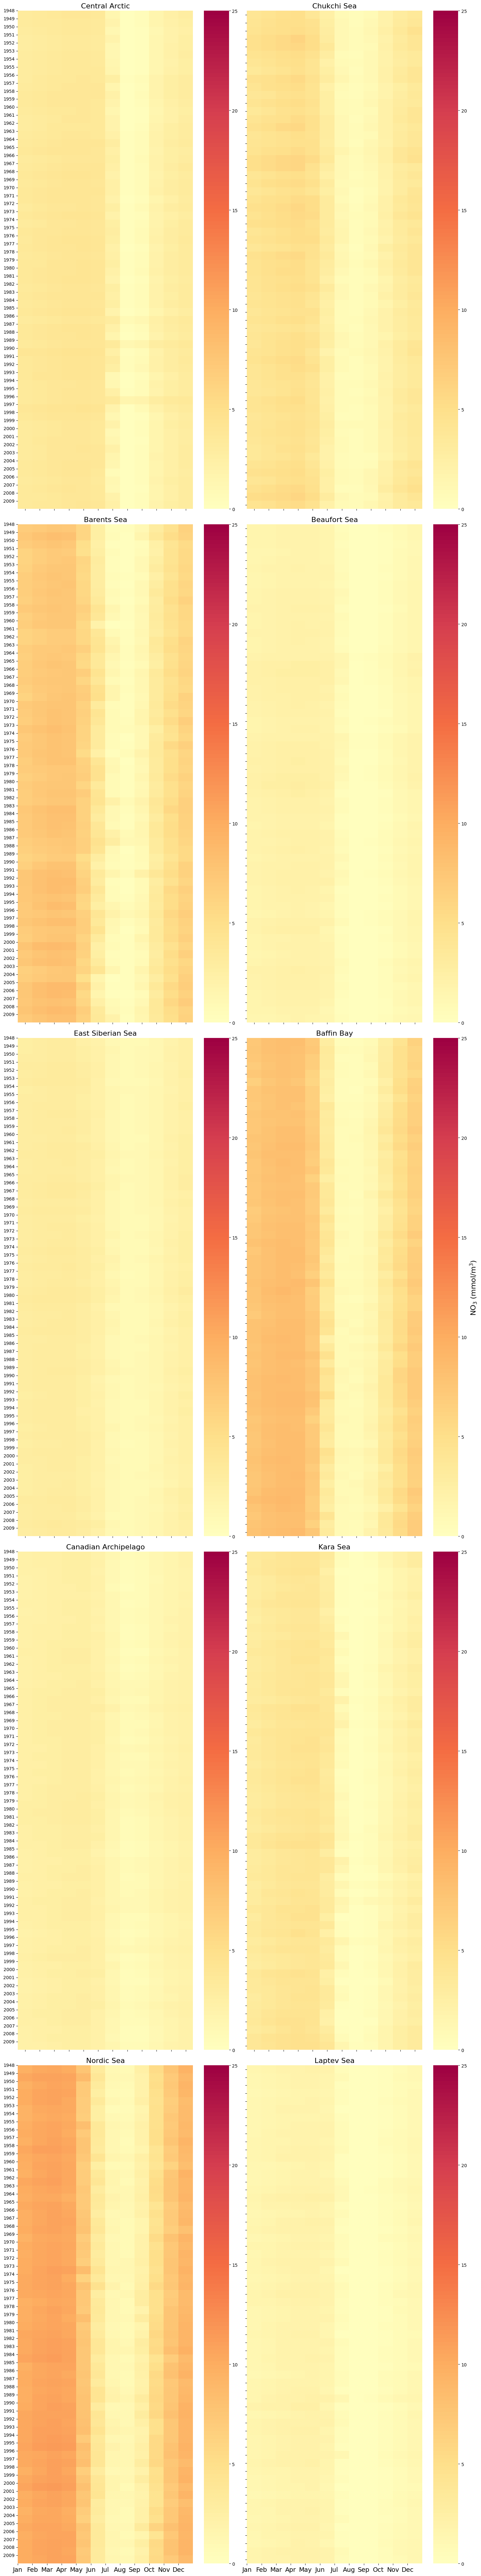

In [8]:
from matplotlib.gridspec import GridSpec
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = ['1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
fig = plt.figure(figsize=(15, 80))
gs = GridSpec(nrows=5, ncols=2)


#subplot 1
ax0 = fig.add_subplot(gs[0, 0])
ax= sns.heatmap(temp_ao[1:63,:],center=0,cmap="Spectral_r",vmin=0,vmax=25)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Central Arctic', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[0, 1])
ax= sns.heatmap(temp_cs[1:63,:],center=0,cmap="Spectral_r",vmin=0,vmax=25)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Chukchi Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[1, 1])
axx2= sns.heatmap(temp_bs[1:63,:],center=0,cmap="Spectral_r",vmin=0,vmax=25)
axx2.set_yticklabels(''); axx2.set_xticklabels('')
axx2.set_title('Beaufort Sea', fontsize=16)
plt.setp(axx2.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = axx2.collections[0].colorbar

ax0 = fig.add_subplot(gs[1, 0])
ax= sns.heatmap(temp_bts[1:63,:],center=0,cmap="Spectral_r",vmin=0,vmax=25)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Barents Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[2, 0])
ax= sns.heatmap(temp_ess[1:63,:],center=0,cmap="Spectral_r",vmin=0,vmax=25)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('East Siberian Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[3, 0])
ax= sns.heatmap(temp_ca[1:63,:],center=0,cmap="Spectral_r",vmin=0,vmax=25)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Canadian Archipelago', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[4, 0])
ax= sns.heatmap(temp_ns[1:63,:],center=0,cmap="Spectral_r",vmin=0,vmax=25)
ax.set_yticks(np.arange(len(years))); ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Nordic Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[3, 1])
ax= sns.heatmap(temp_ks[1:63,:],center=0,cmap="Spectral_r",vmin=0,vmax=25)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Kara Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[4, 1])
ax= sns.heatmap(temp_ls[1:63,:],center=0,cmap="Spectral_r",vmin=0,vmax=25)
ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(''); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Laptev Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[2, 1])
ax= sns.heatmap(temp_bb[1:63,:],center=0,cmap="Spectral_r",vmin=0,vmax=25)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Baffin Bay', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar
cbar.set_label('NO$_3$ (mmol/m$^3$) ', fontsize =16)
fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/nitrate_heatmap_62yr',dpi=600, bbox_inches='tight')

## Now I want to make an annomly plot where I subtract the average month from 1970-2000?

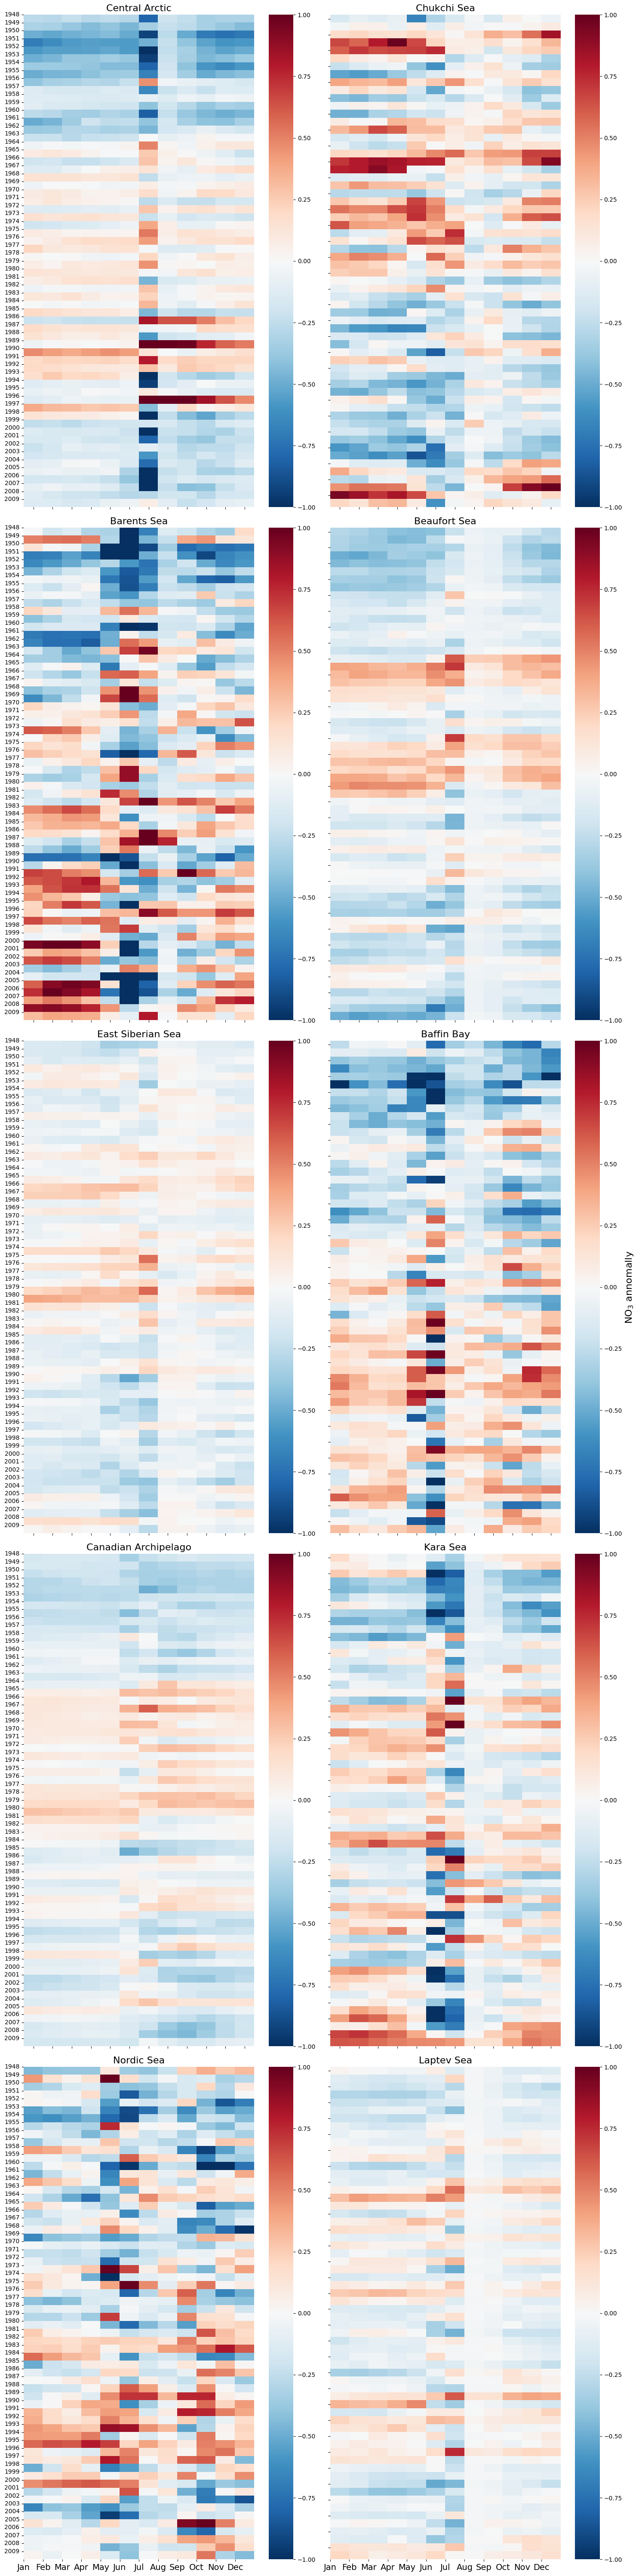

In [9]:
from matplotlib.gridspec import GridSpec
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = ['1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
fig = plt.figure(figsize=(15, 60))
gs = GridSpec(nrows=5, ncols=2)


#subplot 1
ax0 = fig.add_subplot(gs[0, 0])
ax= sns.heatmap(temp_ao[1:63,:]-np.nanmean(temp_ao[10:53,:],axis=0),center=0,cmap="RdBu_r",vmin=-1,vmax=1)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Central Arctic', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[0, 1])
ax= sns.heatmap(temp_cs[1:63,:]-np.nanmean(temp_cs[10:53,:],axis=0),center=0,cmap="RdBu_r",vmin=-1,vmax=1)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Chukchi Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[1, 1])
axx2= sns.heatmap(temp_bs[1:63,:]-np.nanmean(temp_bs[10:53,:],axis=0),center=0,cmap="RdBu_r",vmin=-1,vmax=1)
axx2.set_yticklabels(''); axx2.set_xticklabels('')
axx2.set_title('Beaufort Sea', fontsize=16)
plt.setp(axx2.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = axx2.collections[0].colorbar

ax0 = fig.add_subplot(gs[1, 0])
ax= sns.heatmap(temp_bts[1:63,:]-np.nanmean(temp_bts[10:53,:],axis=0),center=0,cmap="RdBu_r",vmin=-1,vmax=1)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Barents Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[2, 0])
ax= sns.heatmap(temp_ess[1:63,:]-np.nanmean(temp_ess[10:53,:],axis=0),center=0,cmap="RdBu_r",vmin=-1,vmax=1)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('East Siberian Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[3, 0])
ax= sns.heatmap(temp_ca[1:63,:]-np.nanmean(temp_ca[10:53,:],axis=0),center=0,cmap="RdBu_r",vmin=-1,vmax=1)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Canadian Archipelago', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[4, 0])
ax= sns.heatmap(temp_ns[1:63,:]-np.nanmean(temp_ns[10:53,:],axis=0),center=0,cmap="RdBu_r",vmin=-1,vmax=1)
ax.set_yticks(np.arange(len(years))); ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Nordic Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[3, 1])
ax= sns.heatmap(temp_ks[1:63,:]-np.nanmean(temp_ks[10:53,:],axis=0),center=0,cmap="RdBu_r",vmin=-1,vmax=1)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Kara Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[4, 1])
ax= sns.heatmap(temp_ls[1:63,:]-np.nanmean(temp_ls[10:53,:],axis=0),center=0,cmap="RdBu_r",vmin=-1,vmax=1)
ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(''); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Laptev Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[2, 1])
ax= sns.heatmap(temp_bb[1:63,:]-np.nanmean(temp_bb[10:53,:],axis=0),center=0,cmap="RdBu_r",vmin=-1,vmax=1)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Baffin Bay', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar
cbar.set_label('NO$_3$ annomally ', fontsize =16)
fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/nitrate_heatmap_anomaly_62yr',dpi=600, bbox_inches='tight')

## Anomaly 

In [10]:
temp_ao = np.nanmean(temp_ds_inter[:,:,170:180,:] - np.nanmean(temp_ds_inter[31:61,:,170:180,:],axis=(0)),axis=(1,2,3))
temp_cs = np.nanmean(temp_ds_inter[:,:,149:170,0:25]- np.nanmean(temp_ds_inter[31:61,:,149:170,0:25],axis=(0)),axis=(1,2,3))
temp_bs = np.nanmean(temp_ds_inter[:,:,149:170,25:55]- np.nanmean(temp_ds_inter[31:61,:,149:170,25:55],axis=(0)),axis=(1,2,3))
temp_ca = np.nanmean(temp_ds_inter[:,:,149:170,55:110]- np.nanmean(temp_ds_inter[31:61,:,149:170,55:110],axis=(0)),axis=(1,2,3))
temp_bb = np.nanmean(temp_ds_inter[:,:,149:170,110:135]- np.nanmean(temp_ds_inter[31:61,:,149:170,110:135],axis=(0)),axis=(1,2,3))
temp_ess = np.nanmean(temp_ds_inter[:,:,149:170,325:360]- np.nanmean(temp_ds_inter[31:61,:,149:170,325:360],axis=(0)),axis=(1,2,3))
temp_ls = np.nanmean(temp_ds_inter[:,:,149:170,270:325]- np.nanmean(temp_ds_inter[31:61,:,149:170,270:325],axis=(0)),axis=(1,2,3))
temp_ns = np.nanmean(temp_ds_inter[:,:,149:170,155:205]- np.nanmean(temp_ds_inter[31:61,:,149:170,155:205],axis=(0)),axis=(1,2,3))
temp_bts =np.nanmean(temp_ds_inter[:,:,149:170,205:233]- np.nanmean(temp_ds_inter[31:61,:,149:170,205:233],axis=(0)),axis=(1,2,3))
temp_ks = np.nanmean(temp_ds_inter[:,:,149:170,233:270]- np.nanmean(temp_ds_inter[31:61,:,149:170,233:270],axis=(0)),axis=(1,2,3))

In [11]:
yrs = np.arange(1948,2010,1)

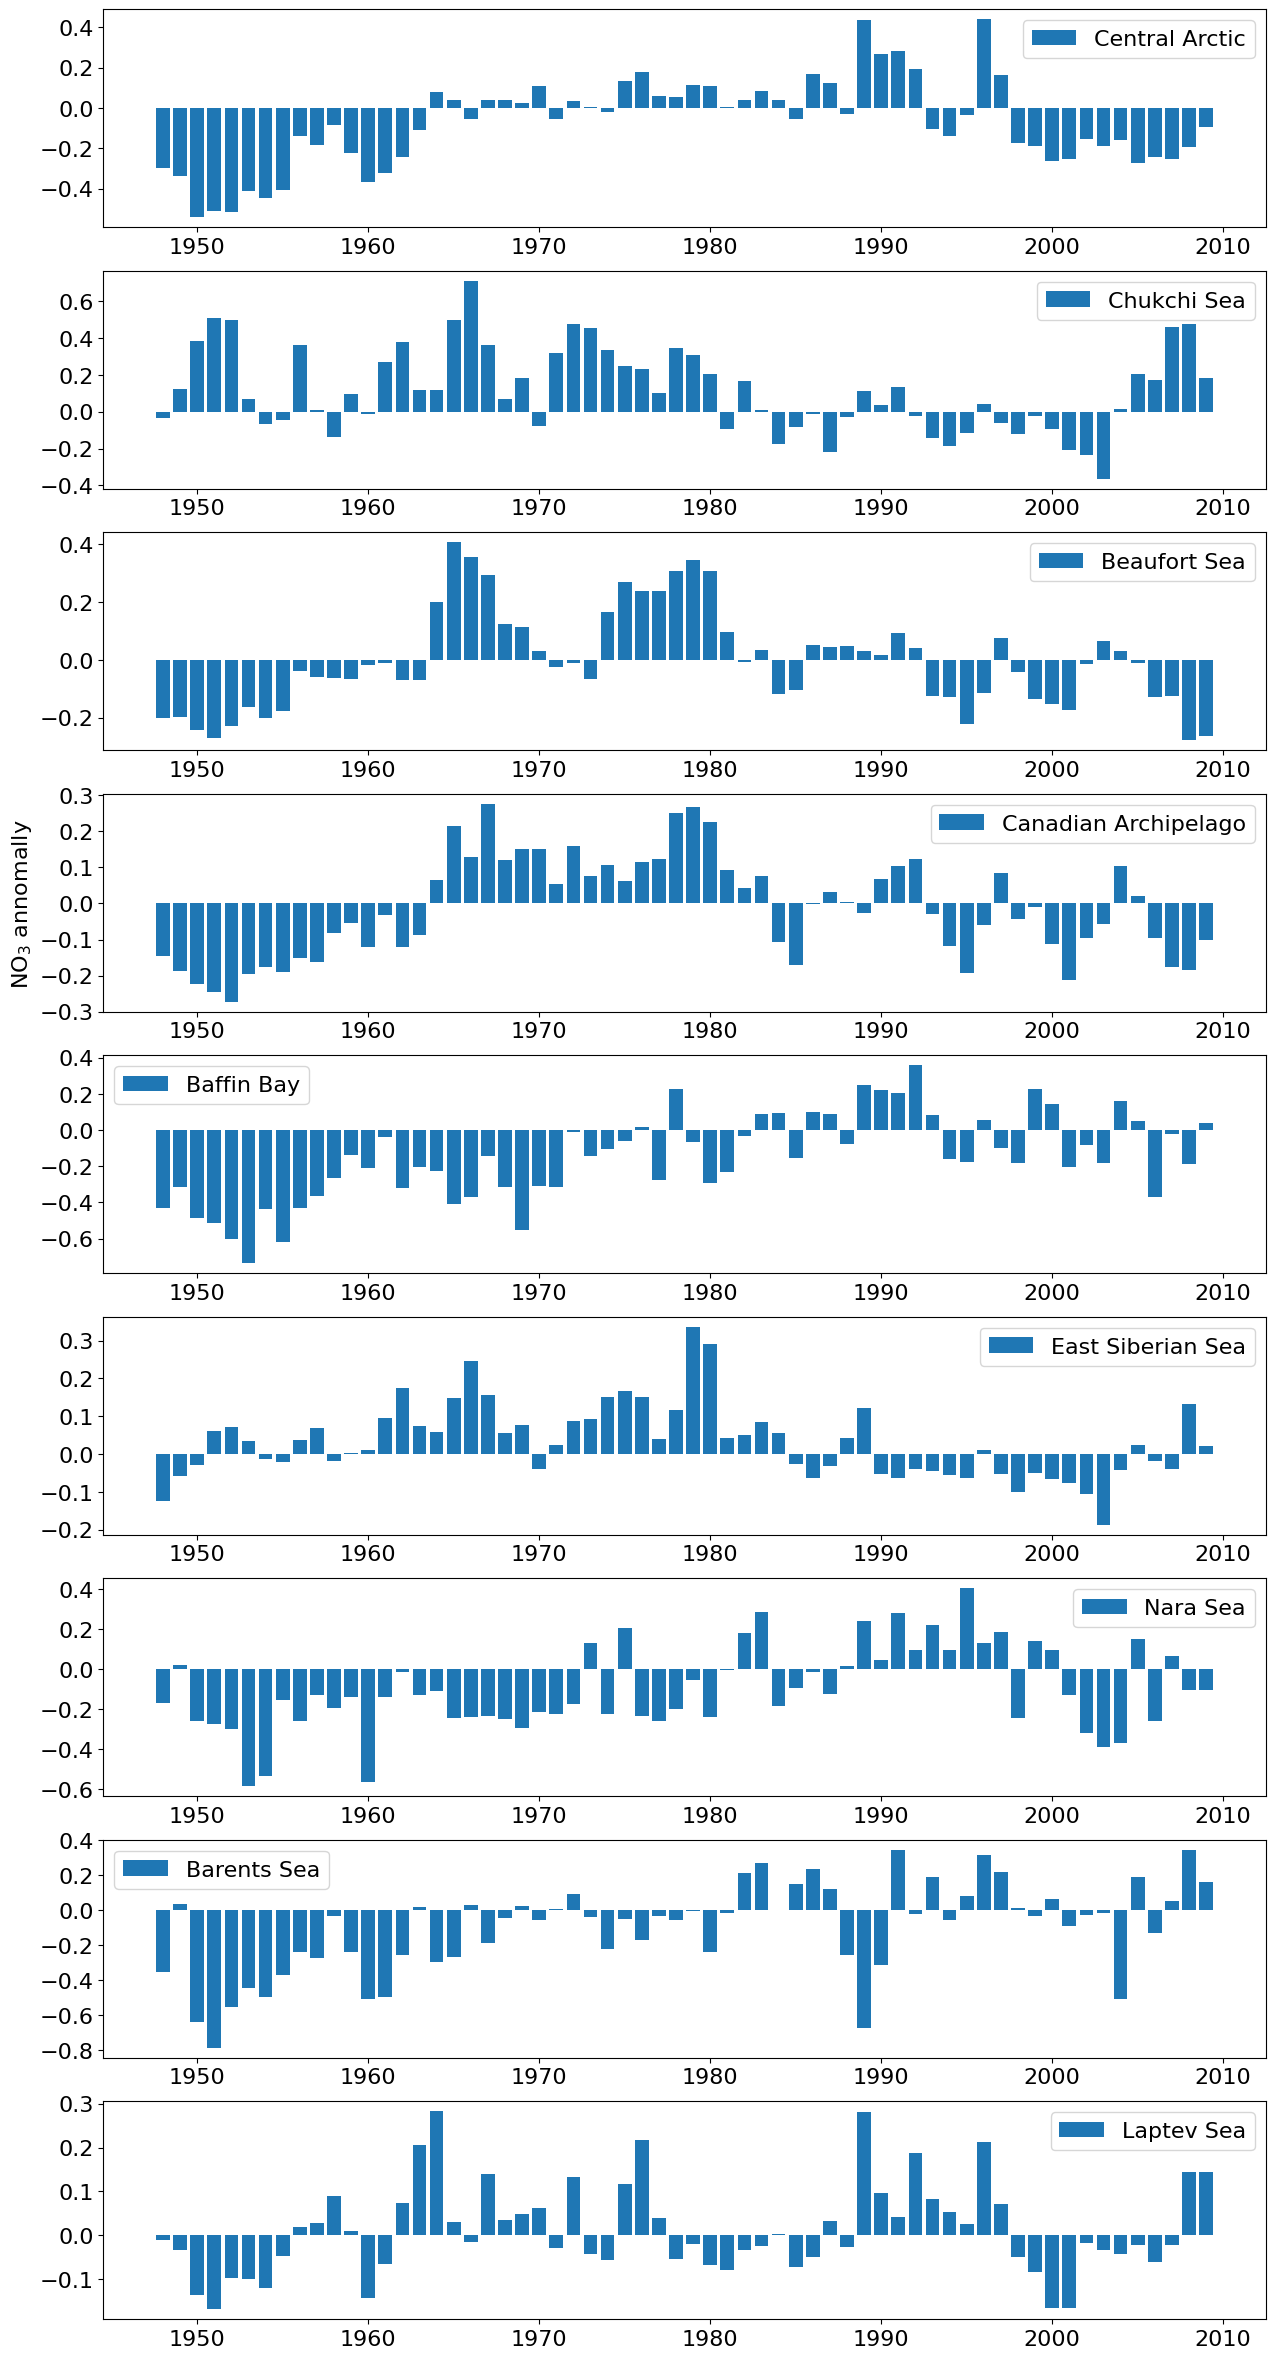

In [12]:
fig =plt.figure(figsize=(15, 30))
ax = fig.add_subplot(911)
plt.bar(yrs,temp_ao[1::], label = 'Central Arctic')
plt.legend(fontsize= 16); plt.yticks(fontsize= 16); plt.xticks(fontsize= 16);

ax = fig.add_subplot(912)
plt.bar(yrs,temp_cs[1::],  label = 'Chukchi Sea')
plt.legend(fontsize= 16); plt.yticks(fontsize= 16); plt.xticks(fontsize= 16);

ax = fig.add_subplot(913)
plt.bar(yrs,temp_bs[1::],  label = 'Beaufort Sea')
plt.legend(fontsize= 16); plt.yticks(fontsize= 16); plt.xticks(fontsize= 16);

ax = fig.add_subplot(914)
plt.bar(yrs,temp_ca[1::],  label = 'Canadian Archipelago')
plt.legend(fontsize= 16); plt.yticks(fontsize= 16); plt.xticks(fontsize= 16);

pylab.ylabel('NO$_3$ annomally ',fontsize = 16)

ax = fig.add_subplot(915)
plt.bar(yrs,temp_bb[1::],  label = 'Baffin Bay')
plt.legend(fontsize= 16); plt.yticks(fontsize= 16); plt.xticks(fontsize= 16);

ax = fig.add_subplot(916)
plt.bar(yrs,temp_ess[1::], label = 'East Siberian Sea')
plt.legend(fontsize= 16); plt.yticks(fontsize= 16); plt.xticks(fontsize= 16);

ax = fig.add_subplot(917)
plt.bar(yrs,temp_ns[1::],  label = 'Nara Sea')
plt.legend(fontsize= 16); plt.yticks(fontsize= 16); plt.xticks(fontsize= 16);

ax = fig.add_subplot(918)
plt.bar(yrs,temp_bts[1::],  label = 'Barents Sea')
plt.legend(fontsize= 16); plt.yticks(fontsize= 16); plt.xticks(fontsize= 16);

ax = fig.add_subplot(919)
plt.bar(yrs,temp_ls[1::],  label = 'Laptev Sea')
plt.legend(fontsize= 16); plt.yticks(fontsize= 16); plt.xticks(fontsize= 16);

#ax = fig.add_subplot(5210)
#pylab.plot(ds.time,temp_ks, 'o-', color='gray', label = 'Kara Sea')
#plt.legend(fontsize= 16); plt.yticks(fontsize= 16); plt.xticks(fontsize= 16);
plt.show()

## Create a plot with seasonality in temperature, and interannual variation. 

In [13]:
temp_ao = np.nanmean(temp_ds_inter[:,:,170:180,:], axis=(2,3))
temp_cs = np.nanmean(temp_ds_inter[:,:,149:170,0:25], axis = (2,3))
temp_bs = np.nanmean(temp_ds_inter[:,:,149:170,25:55], axis = (2,3))
temp_ca = np.nanmean(temp_ds_inter[:,:,149:170,55:110], axis = (2,3))
temp_bb = np.nanmean(temp_ds_inter[:,:,149:170,110:135], axis = (2,3))
temp_ess = np.nanmean(temp_ds_inter[:,:,149:170,325:360], axis = (2,3))
temp_ls = np.nanmean(temp_ds_inter[:,:,149:170,270:325], axis = (2,3))
temp_ns = np.nanmean(temp_ds_inter[:,:,149:170,155:205], axis = (2,3))
temp_bts =np.nanmean(temp_ds_inter[:,:,149:170,205:233], axis = (2,3))
temp_ks = np.nanmean(temp_ds_inter[:,:,149:170,233:270], axis = (2,3))

In [14]:
# This is the error on the observations
err_ao = np.nanstd(temp_ao,axis=0)
err_cs = np.nanstd(temp_cs,axis=0)
err_bs = np.nanstd(temp_bs,axis=0)
err_ca = np.nanstd(temp_ca,axis=0)
err_bb = np.nanstd(temp_bb,axis=0)
err_ess = np.nanstd(temp_ess,axis=0)
err_ls = np.nanstd(temp_ls,axis=0)
err_ns = np.nanstd(temp_ns,axis=0)
err_bts = np.nanstd(temp_bts,axis=0)
err_ks = np.nanstd(temp_ks,axis=0)

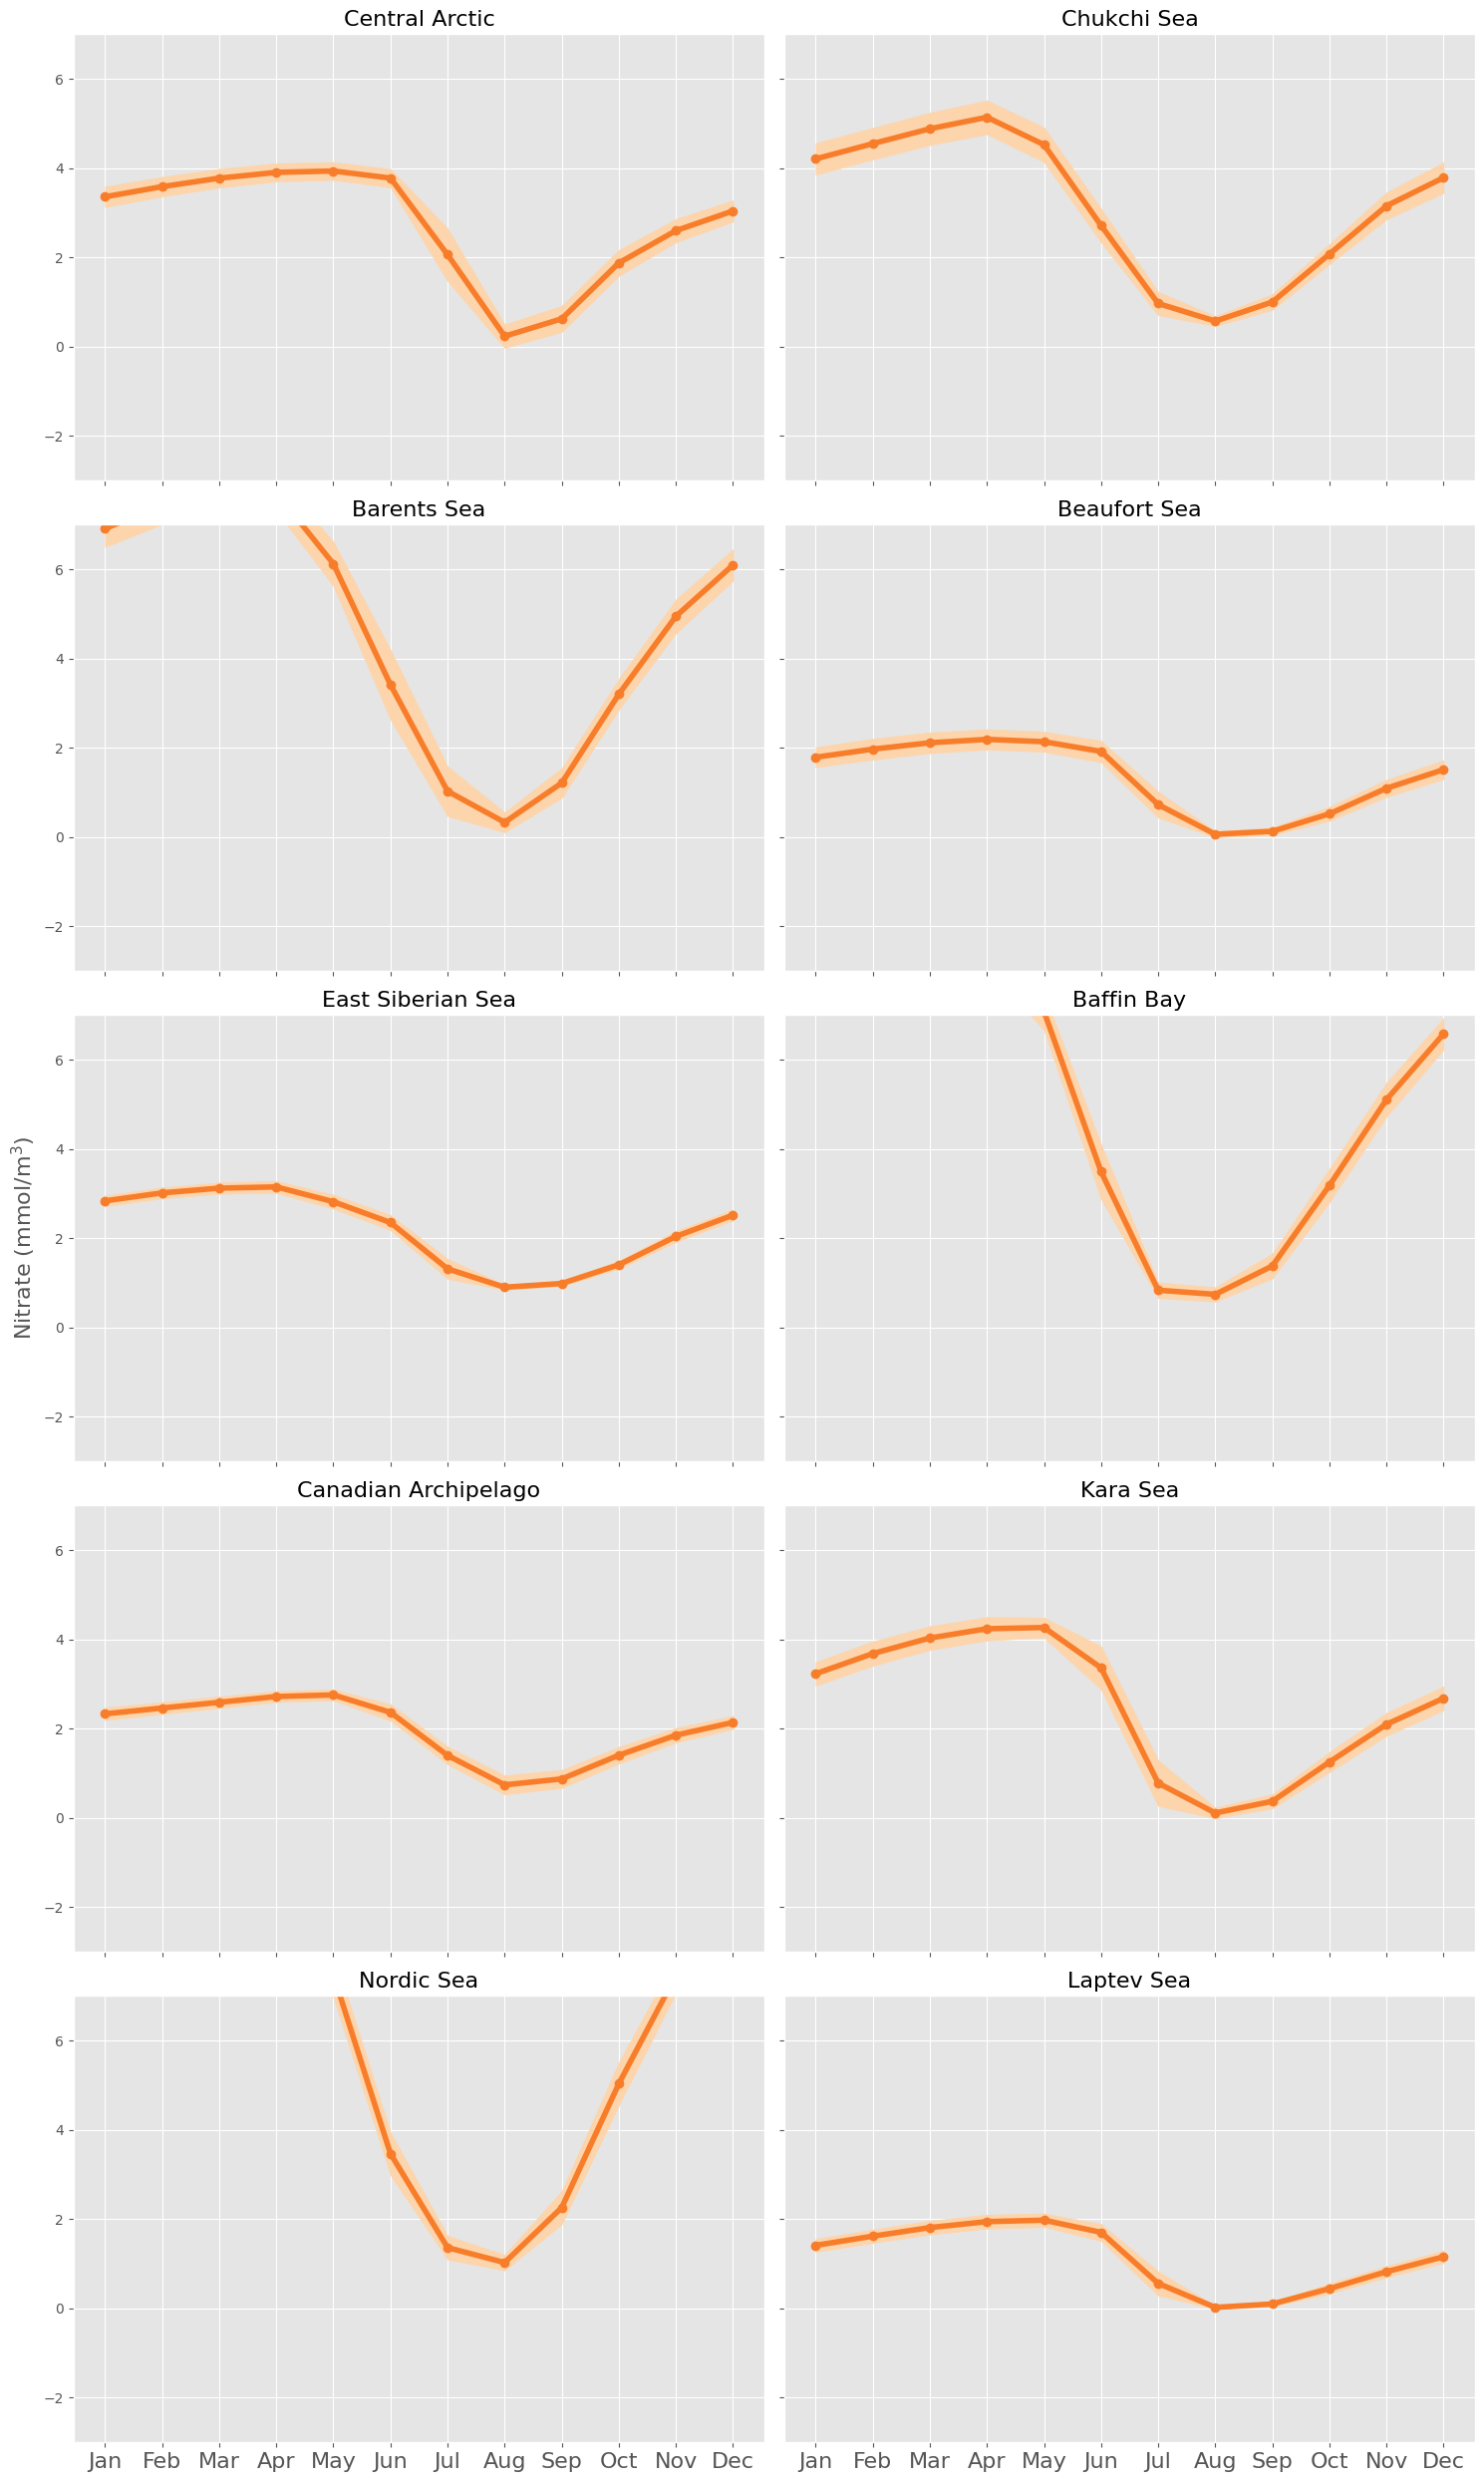

In [15]:
plt.style.use('ggplot')

from matplotlib.gridspec import GridSpec
import matplotlib
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(months,np.nanmean(temp_ao,axis=0), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(months, np.nanmean(temp_ao,axis=0)-err_ao,np.nanmean(temp_ao,axis=0)+err_ao, color=cmap(2))
ax1.set_title('Central Arctic', fontsize=16); #ax1.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax1.set_ylim(-3,7);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(months,np.nanmean(temp_bts,axis=0), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(months, np.nanmean(temp_bts,axis=0)-err_bts,np.nanmean(temp_bts,axis=0)+err_bts, color=cmap(2))
ax2.set_title('Barents Sea', fontsize=16); #ax2.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax2.set_ylim(-3,7);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(months,np.nanmean(temp_cs,axis=0), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(months, np.nanmean(temp_cs,axis=0)-err_cs,np.nanmean(temp_cs,axis=0)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(-3,7);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(months,np.nanmean(temp_ess,axis=0), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(months, np.nanmean(temp_ess,axis=0)-err_ess,np.nanmean(temp_ess,axis=0)+err_ess, color=cmap(2))
ax4.set_ylabel('Nitrate (mmol/m$^3$)', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); #ax4.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax4.set_ylim(-3,7);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(months,np.nanmean(temp_ca,axis=0), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(months, np.nanmean(temp_ca,axis=0)-err_ca,np.nanmean(temp_ca,axis=0)+err_ca, color=cmap(2))
ax5.set_title('Canadian Archipelago', fontsize=16); #ax5.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax5.set_ylim(-3,7);
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(months,np.nanmean(temp_ns,axis=0), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(months, np.nanmean(temp_ns,axis=0)-err_ns,np.nanmean(temp_ns,axis=0)+err_ns, color=cmap(2))
ax6.set_title('Nordic Sea', fontsize=16); #ax6.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax6.set_ylim(-3,7);
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(months,np.nanmean(temp_bs,axis=0), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(months, np.nanmean(temp_bs,axis=0)-err_bs,np.nanmean(temp_bs,axis=0)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(-3,7);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(months,np.nanmean(temp_bb,axis=0), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(months, np.nanmean(temp_bb,axis=0)-err_bb,np.nanmean(temp_bb,axis=0)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(-3,7);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(months,np.nanmean(temp_ks,axis=0), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(months, np.nanmean(temp_ks,axis=0)-err_ks,np.nanmean(temp_ks,axis=0)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(-3,7);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(months,np.nanmean(temp_ls,axis=0), '-o', color=cmap(5),linewidth=4)
ax.fill_between(months, np.nanmean(temp_ls,axis=0)-err_ls,np.nanmean(temp_ls,axis=0)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)
ax.set_ylim(-3,7);  ax.set_yticklabels(''); 
fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/nitrate_interannual_climatology',dpi=600, bbox_inches='tight')


## Create one plot in every region, with annual temperature at every year, and monthly variability in the error bars?. 

In [16]:
# This is the error on the observations
err_ao = np.nanstd(temp_ao[1:62],axis=1)
err_cs = np.nanstd(temp_cs[1:62],axis=1)
err_bs = np.nanstd(temp_bs[1:62],axis=1)
err_ca = np.nanstd(temp_ca[1:62],axis=1)
err_bb = np.nanstd(temp_bb[1:62],axis=1)
err_ess = np.nanstd(temp_ess[1:62],axis=1)
err_ls = np.nanstd(temp_ls[1:62],axis=1)
err_ns = np.nanstd(temp_ns[1:62],axis=1)
err_bts = np.nanstd(temp_bts[1:62],axis=1)
err_ks = np.nanstd(temp_ks[1:62],axis=1)

In [17]:
years = np.arange(1946,2010,1)

In [18]:
temp_ao[1:62].shape

(61, 12)

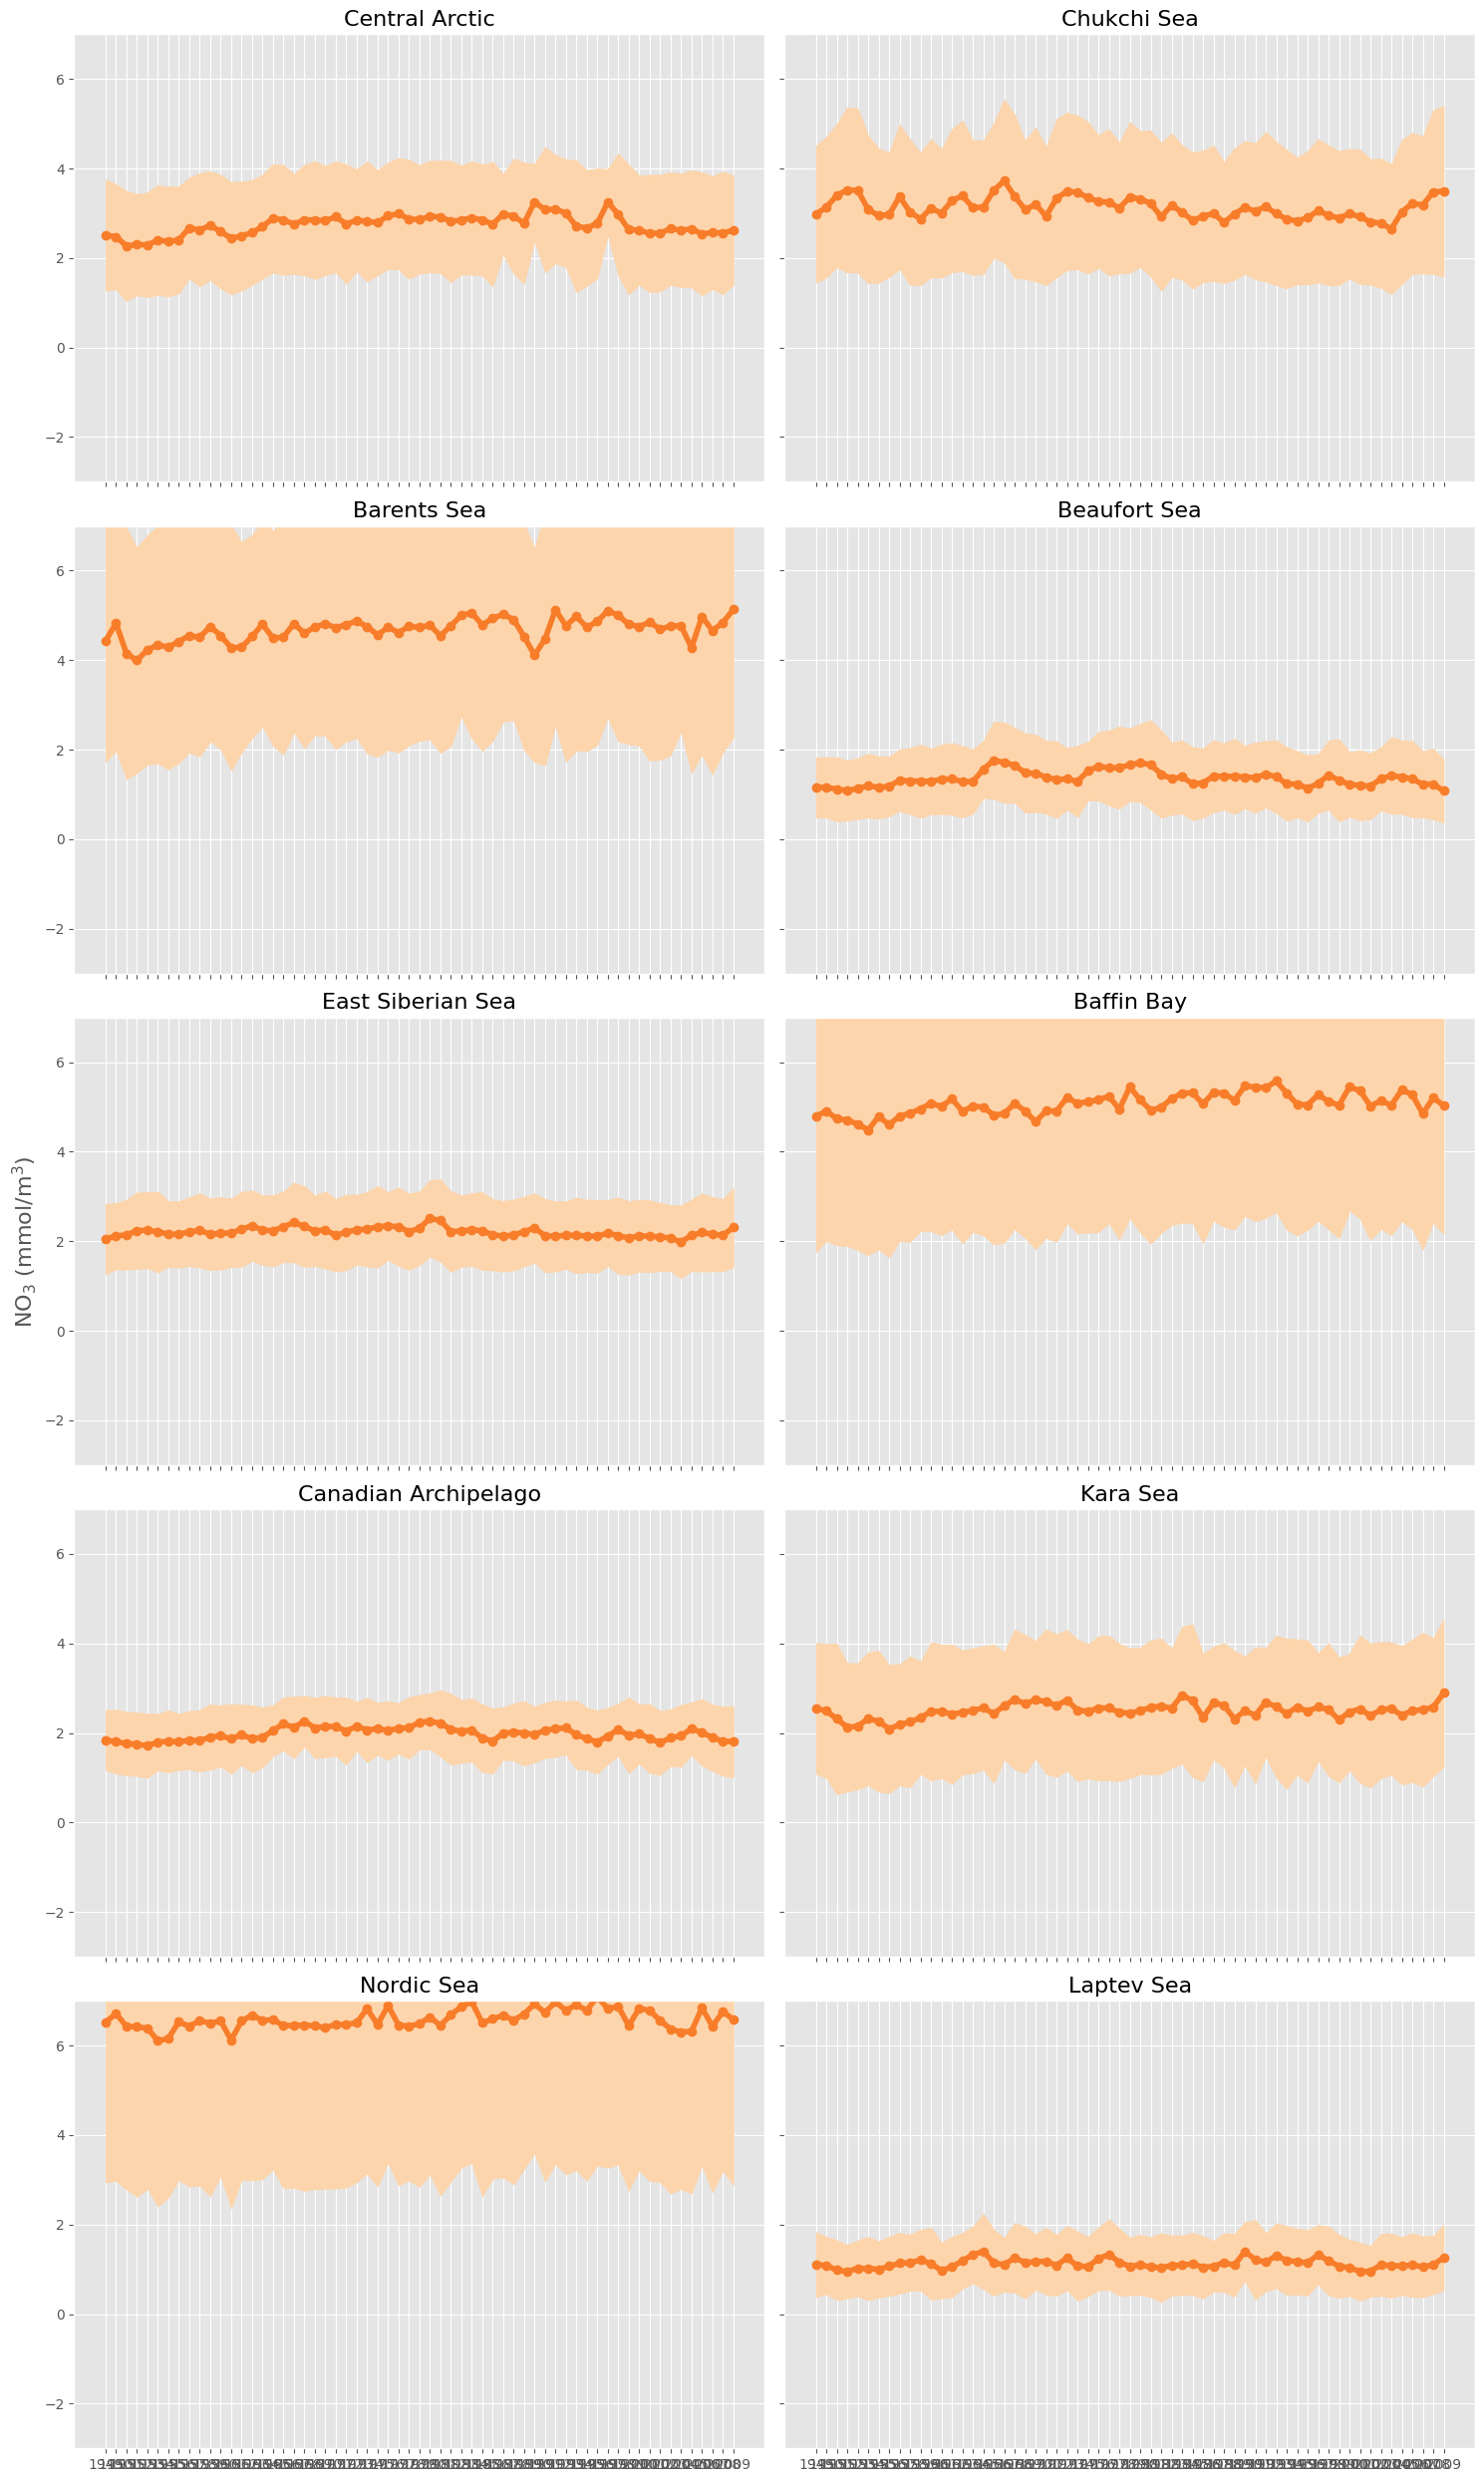

In [19]:
plt.style.use('ggplot')

from matplotlib.gridspec import GridSpec
import matplotlib
years = ['1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(years,np.nanmean(temp_ao[1:62],axis=1), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(years, np.nanmean(temp_ao[1:62],axis=1)-err_ao,np.nanmean(temp_ao[1:62],axis=1)+err_ao, color=cmap(2))
ax1.set_title('Central Arctic', fontsize=16); #ax1.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax1.set_ylim(-3,7);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(years,np.nanmean(temp_bts[1:62],axis=1), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(years, np.nanmean(temp_bts[1:62],axis=1)-err_bts,np.nanmean(temp_bts[1:62],axis=1)+err_bts, color=cmap(2))
ax2.set_title('Barents Sea', fontsize=16); #ax2.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax2.set_ylim(-3,7);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(years,np.nanmean(temp_cs[1:62],axis=1), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(years, np.nanmean(temp_cs[1:62],axis=1)-err_cs,np.nanmean(temp_cs[1:62],axis=1)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(-3,7);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(years,np.nanmean(temp_ess[1:62],axis=1), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(years, np.nanmean(temp_ess[1:62],axis=1)-err_ess,np.nanmean(temp_ess[1:62],axis=1)+err_ess, color=cmap(2))
ax4.set_ylabel('NO$_3$ (mmol/m$^3$)', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); #ax4.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax4.set_ylim(-3,7);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(years,np.nanmean(temp_ca[1:62],axis=1), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(years, np.nanmean(temp_ca[1:62],axis=1)-err_ca,np.nanmean(temp_ca[1:62],axis=1)+err_ca, color=cmap(2))
ax5.set_title('Canadian Archipelago', fontsize=16); #ax5.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax5.set_ylim(-3,7); 
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(years,np.nanmean(temp_ns[1:62],axis=1), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(years, np.nanmean(temp_ns[1:62],axis=1)-err_ns,np.nanmean(temp_ns[1:62],axis=1)+err_ns, color=cmap(2))
ax6.set_title('Nordic Sea', fontsize=16); #ax6.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax6.set_ylim(-3,7);
ax6.set_xticklabels(['1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(years,np.nanmean(temp_bs[1:62],axis=1), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(years, np.nanmean(temp_bs[1:62],axis=1)-err_bs,np.nanmean(temp_bs[1:62],axis=1)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(-3,7);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(years,np.nanmean(temp_bb[1:62],axis=1), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(years, np.nanmean(temp_bb[1:62],axis=1)-err_bb,np.nanmean(temp_bb[1:62],axis=1)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(-3,7);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(years,np.nanmean(temp_ks[1:62],axis=1), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(years, np.nanmean(temp_ks[1:62],axis=1)-err_ks,np.nanmean(temp_ks[1:62],axis=1)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(-3,7);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(years,np.nanmean(temp_ls[1:62],axis=1), '-o', color=cmap(5),linewidth=4)
ax.fill_between(years, np.nanmean(temp_ls[1:62],axis=1)-err_ls,np.nanmean(temp_ls[1:62],axis=1)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
ax.set_ylim(-3,7);  ax.set_yticklabels(''); 
fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/nitrate_observations_annual_climatology',dpi=600, bbox_inches='tight')

## Now let's try to make an anomaly plot

In [20]:
temp_ao_anom = temp_ao-np.nanmean(temp_ao,axis=0)
temp_cs_anom = temp_cs-np.nanmean(temp_cs,axis=0)
temp_bs_anom = temp_bs-np.nanmean(temp_bs,axis=0)
temp_ca_anom = temp_ca-np.nanmean(temp_ca,axis=0)
temp_bb_anom = temp_bb-np.nanmean(temp_bb,axis=0)
temp_ess_anom = temp_ess-np.nanmean(temp_ess,axis=0)
temp_ls_anom = temp_ls-np.nanmean(temp_ls,axis=0)
temp_ns_anom = temp_ns-np.nanmean(temp_ns,axis=0)
temp_bts_anom =temp_bts-np.nanmean(temp_bts,axis=0)
temp_ks_anom = temp_ks-np.nanmean(temp_ks,axis=0)

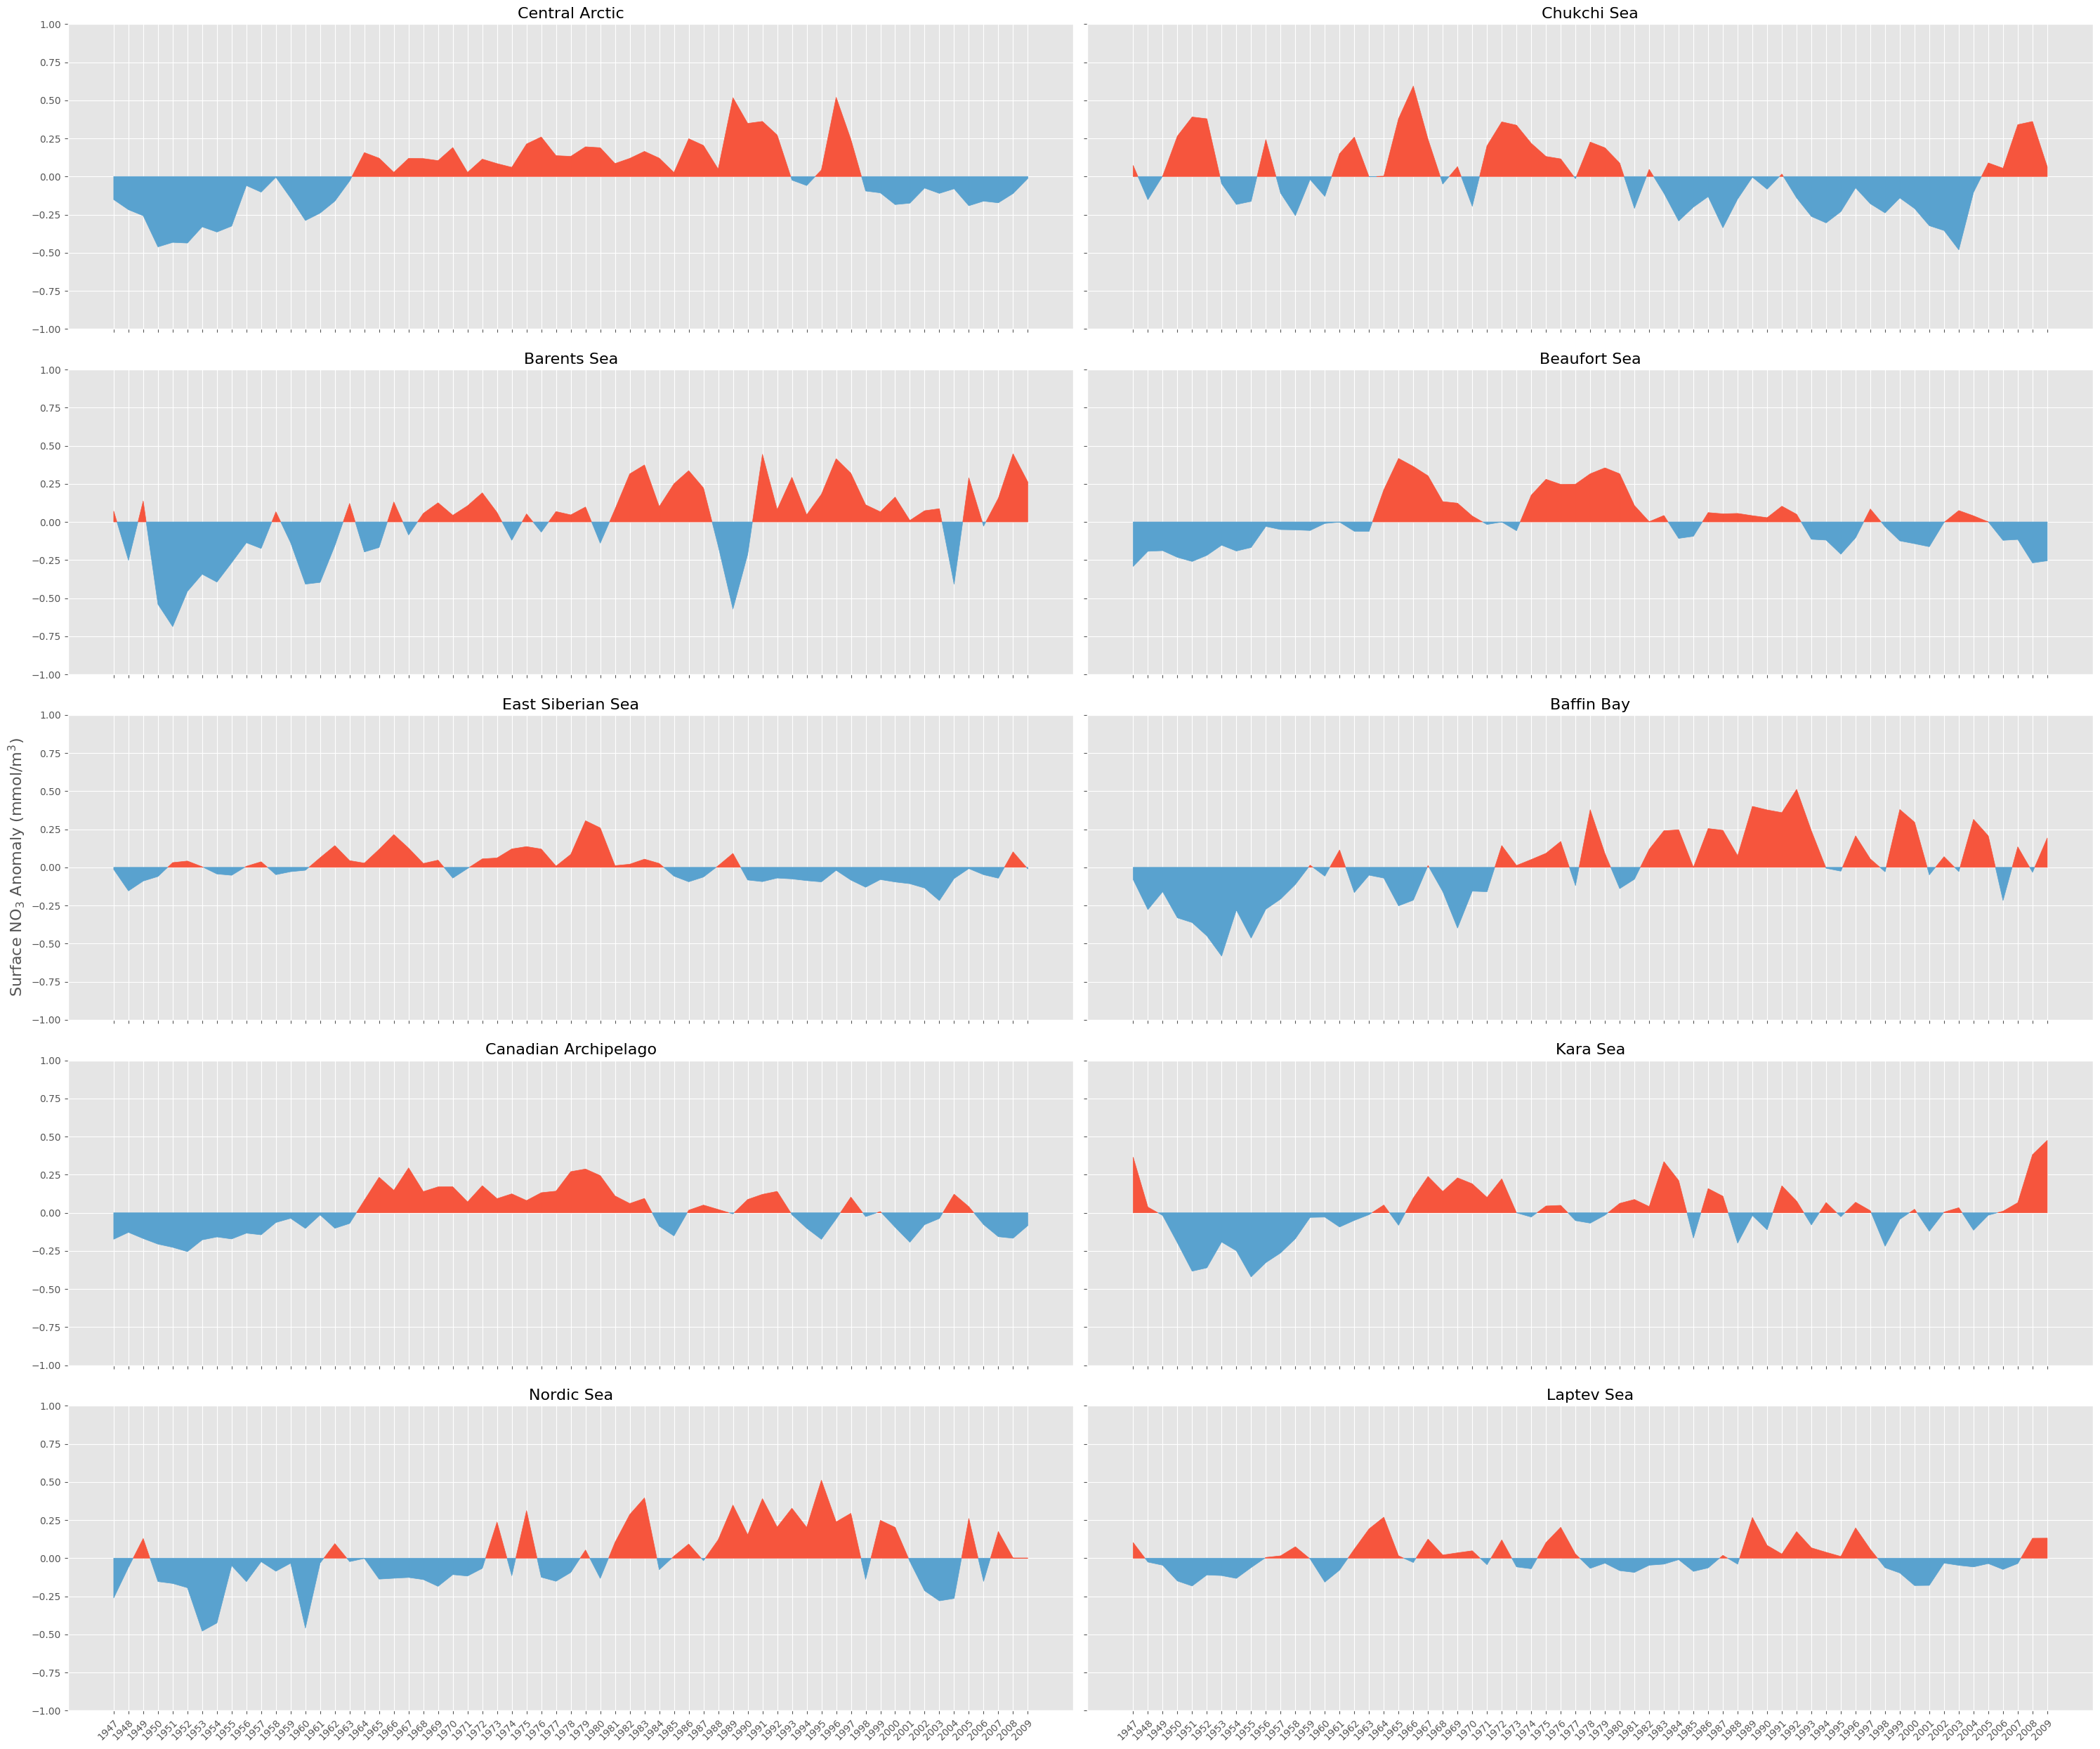

In [21]:
plt.style.use('ggplot')

years = [ '1947','1948', '1949',
         '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959',
         "1960",  '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
         "1970", '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
         "1980", '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
         "1990", '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
         '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(temp_ao_anom,axis=1), where=np.nanmean(temp_ao_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(temp_ao_anom,axis=1), where=np.nanmean(temp_ao_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax1.set_title('Central Arctic', fontsize=16); 
ax1.set_ylim(-1,1);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
ax2.fill_between(years, np.nanmean(temp_bts_anom,axis=1), where=np.nanmean(temp_bts_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax2.fill_between(years, np.nanmean(temp_bts_anom,axis=1), where=np.nanmean(temp_bts_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax2.set_title('Barents Sea', fontsize=16); 
ax2.set_ylim(-1,1);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
ax3.fill_between(years, np.nanmean(temp_cs_anom,axis=1), where=np.nanmean(temp_cs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax3.fill_between(years, np.nanmean(temp_cs_anom,axis=1), where=np.nanmean(temp_cs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(-1,1);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
ax4.fill_between(years, np.nanmean(temp_ess_anom,axis=1), where=np.nanmean(temp_ess_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax4.fill_between(years, np.nanmean(temp_ess_anom,axis=1), where=np.nanmean(temp_ess_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax4.set_ylabel('Surface NO$_3$ Anomaly (mmol/m$^3$)', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); 
ax4.set_ylim(-1,1);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
ax5.fill_between(years, np.nanmean(temp_ca_anom,axis=1), where=np.nanmean(temp_ca_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax5.fill_between(years, np.nanmean(temp_ca_anom,axis=1), where=np.nanmean(temp_ca_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax5.set_title('Canadian Archipelago', fontsize=16); 
ax5.set_ylim(-1,1);
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
ax6.fill_between(years, np.nanmean(temp_ns_anom,axis=1), where=np.nanmean(temp_ns_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax6.fill_between(years, np.nanmean(temp_ns_anom,axis=1), where=np.nanmean(temp_ns_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax6.set_title('Nordic Sea', fontsize=16); 
ax6.set_ylim(-1,1);
ax6.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax6.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax7 = fig.add_subplot(gs[1, 1]);
ax7.fill_between(years, np.nanmean(temp_bs_anom,axis=1), where=np.nanmean(temp_bs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax7.fill_between(years, np.nanmean(temp_bs_anom,axis=1), where=np.nanmean(temp_bs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(-1,1);

ax8 = fig.add_subplot(gs[2, 1]);
ax8.fill_between(years, np.nanmean(temp_bb_anom,axis=1), where=np.nanmean(temp_bb_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax8.fill_between(years, np.nanmean(temp_bb_anom,axis=1), where=np.nanmean(temp_bb_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(-1,1);

ax9 = fig.add_subplot(gs[3, 1]);
ax9.fill_between(years, np.nanmean(temp_ks_anom,axis=1), where=np.nanmean(temp_ks_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax9.fill_between(years, np.nanmean(temp_ks_anom,axis=1), where=np.nanmean(temp_ks_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(-1,1);

ax = fig.add_subplot(gs[4,1]);
ax.fill_between(years, np.nanmean(temp_ls_anom,axis=1), where=np.nanmean(temp_ls_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax.fill_between(years, np.nanmean(temp_ls_anom,axis=1), where=np.nanmean(temp_ls_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
                    "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
                    "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
                    "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
                    "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
                    '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.set_ylim(-1,1);  ax.set_yticklabels(''); 
fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/nitrate_anomaly_interannual',dpi=600, bbox_inches='tight')